In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
sys.path.append('/Users/mamba/Documents') #TODO: replace with direct import
import Code.pertpy.pertpy as pt

In [88]:
#import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from gprofiler import GProfiler
from tqdm import tqdm

# Associations

In [78]:
blm_pbs_associations = pd.read_csv("dialogue_output/day 10/blm_pbs_associations.csv", index_col=0)
blm_nintedanib_associations = pd.read_csv("dialogue_output/day 10/blm_nintedanib_associations.csv", index_col=0)
blm_GLPG1690_associations = pd.read_csv("dialogue_output/day 10/blm_GLPG1690_associations.csv", index_col=0)
blm_GLPG1205_associations = pd.read_csv("dialogue_output/day 10/blm_GLPG1205_associations.csv", index_col=0)
blm_combo_associations = pd.read_csv("dialogue_output/day 10/blm_combo_associations.csv", index_col=0)

association_dfs = [blm_pbs_associations, blm_nintedanib_associations, blm_GLPG1690_associations, blm_GLPG1205_associations, blm_combo_associations]
treatments = ["BLM+PBS", "BLM+Nintedanib", "BLM+GLPG1690", "BLM+GLPG1205", "BLM+Combo"]

In [83]:
blm_pbs_associations

,mcp_0,mcp_1,mcp_2,mcp_3,mcp_4,mcp_5
Airway Epithelial Cells,0.012414,0.025519,0.157133,0.091524,0.040751,0.807780
Capillary Cells,0.010748,0.041781,0.184406,0.091524,0.089666,0.986060
Dendritic Cells,0.048121,0.032906,0.157133,0.108677,0.040751,0.807780
Fibroblasts,0.010695,0.072409,0.157133,0.091524,0.151944,0.986060
Lymphocytes,0.023482,0.025519,0.157133,0.091524,0.080758,0.807780
Macrophages,0.007745,0.066215,0.180646,0.042985,0.040751,0.929820
Megakaryocytes and Basophils,0.053570,0.141356,0.157133,0.210281,0.040751,0.767376
Mesothelial Cells,0.087627,0.227292,0.184406,0.266466,0.673281,0.986060
Monocytes,0.024363,0.025519,0.184406,0.193935,0.080758,0.910670
NK Cells,0.007618,0.041781,0.157133,0.035985,0.040751,0.807780


In [79]:
def plot_heatmap(associations_df, vmax=None, create_fig=True, cbar=True, cmap="viridis"):
    log_associations_df = associations_df.copy()
    for mcp_nr in range(6):
        log_associations_df[f"MCP {mcp_nr + 1}"] = -1 * np.log10(log_associations_df[f"mcp_{mcp_nr}"])
    log_associations_df = log_associations_df.drop(columns=[f"mcp_{mcp_nr}" for mcp_nr in range(6)])
    
    if create_fig:
        plt.figure(figsize=(2.2, 6))
    if cbar:
        sns.heatmap(log_associations_df, vmin=0, vmax=vmax, cbar=True, cmap=cmap)
    else:
        sns.heatmap(log_associations_df, vmin=0, vmax=vmax, cbar=False, cmap=cmap)

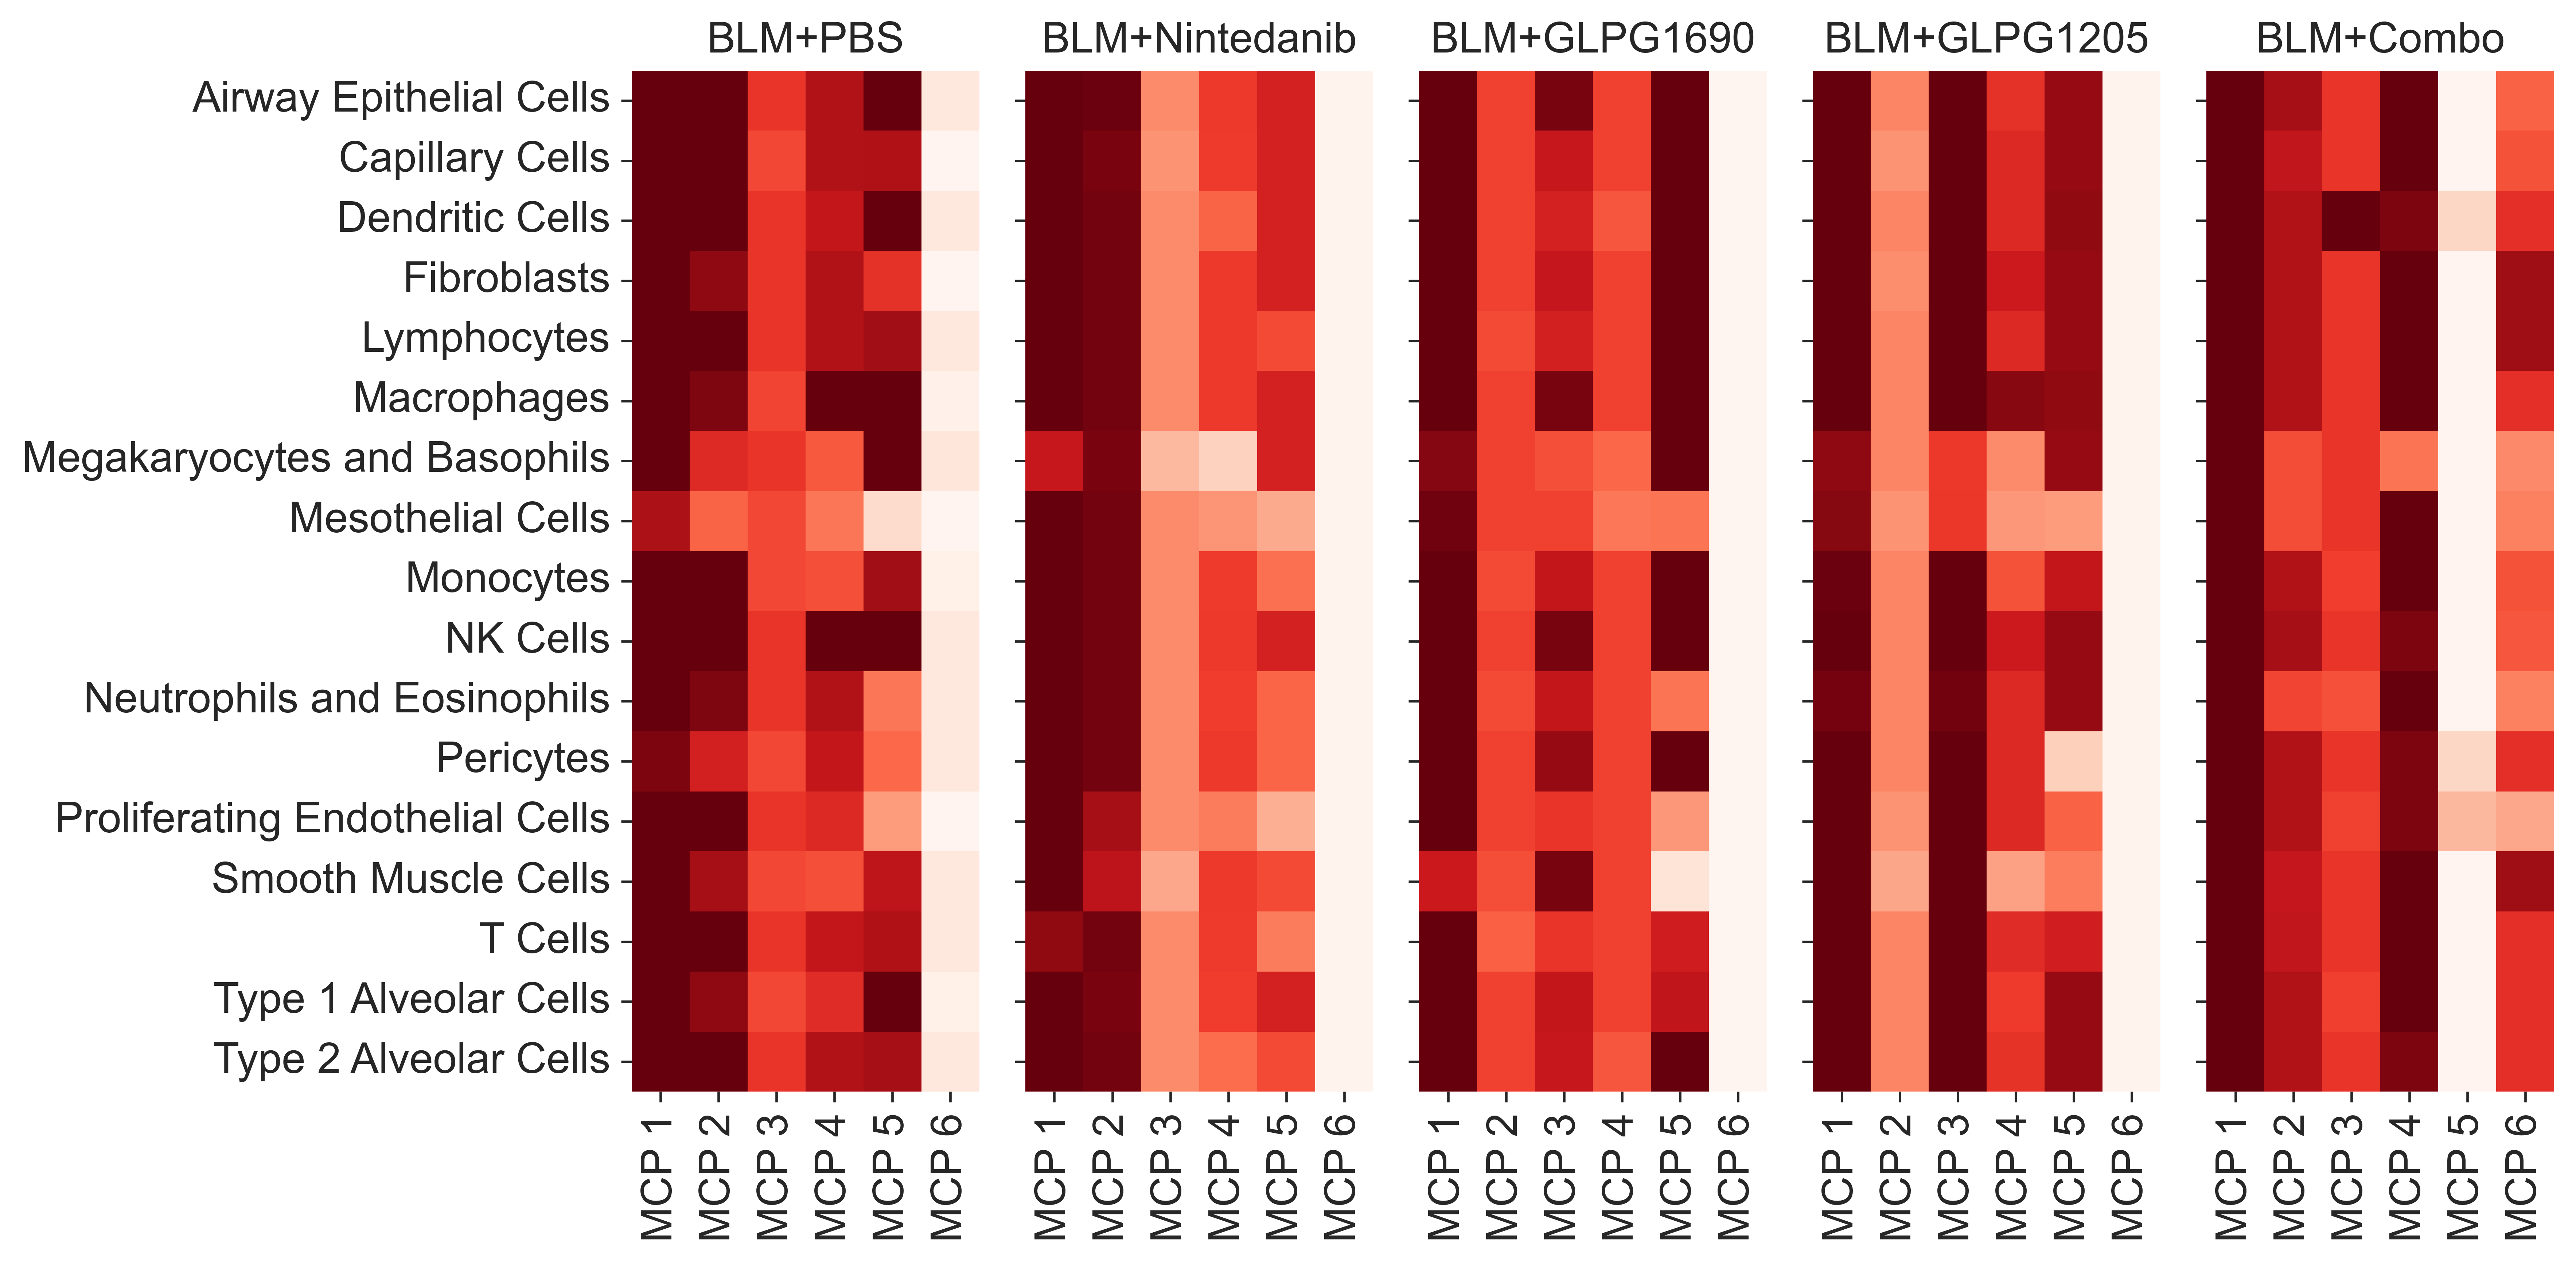

In [80]:
# Plot all three in one plot with subplots, take the global max as vmax
global_max = (-1 * np.log10([df.max() for df in association_dfs])).max()

plt.subplots(1, len(association_dfs), figsize=(12, 6), sharey=True)
for i, associations_df in enumerate(association_dfs):
    plt.subplot(1, len(association_dfs), i + 1)
    plot_heatmap(associations_df, vmax=global_max, create_fig=False, cbar=False, cmap="Reds")
    plt.title(treatments[i])

plt.tight_layout()
plt.savefig("figures/heatmap_mcp_associations.pdf")
plt.show()

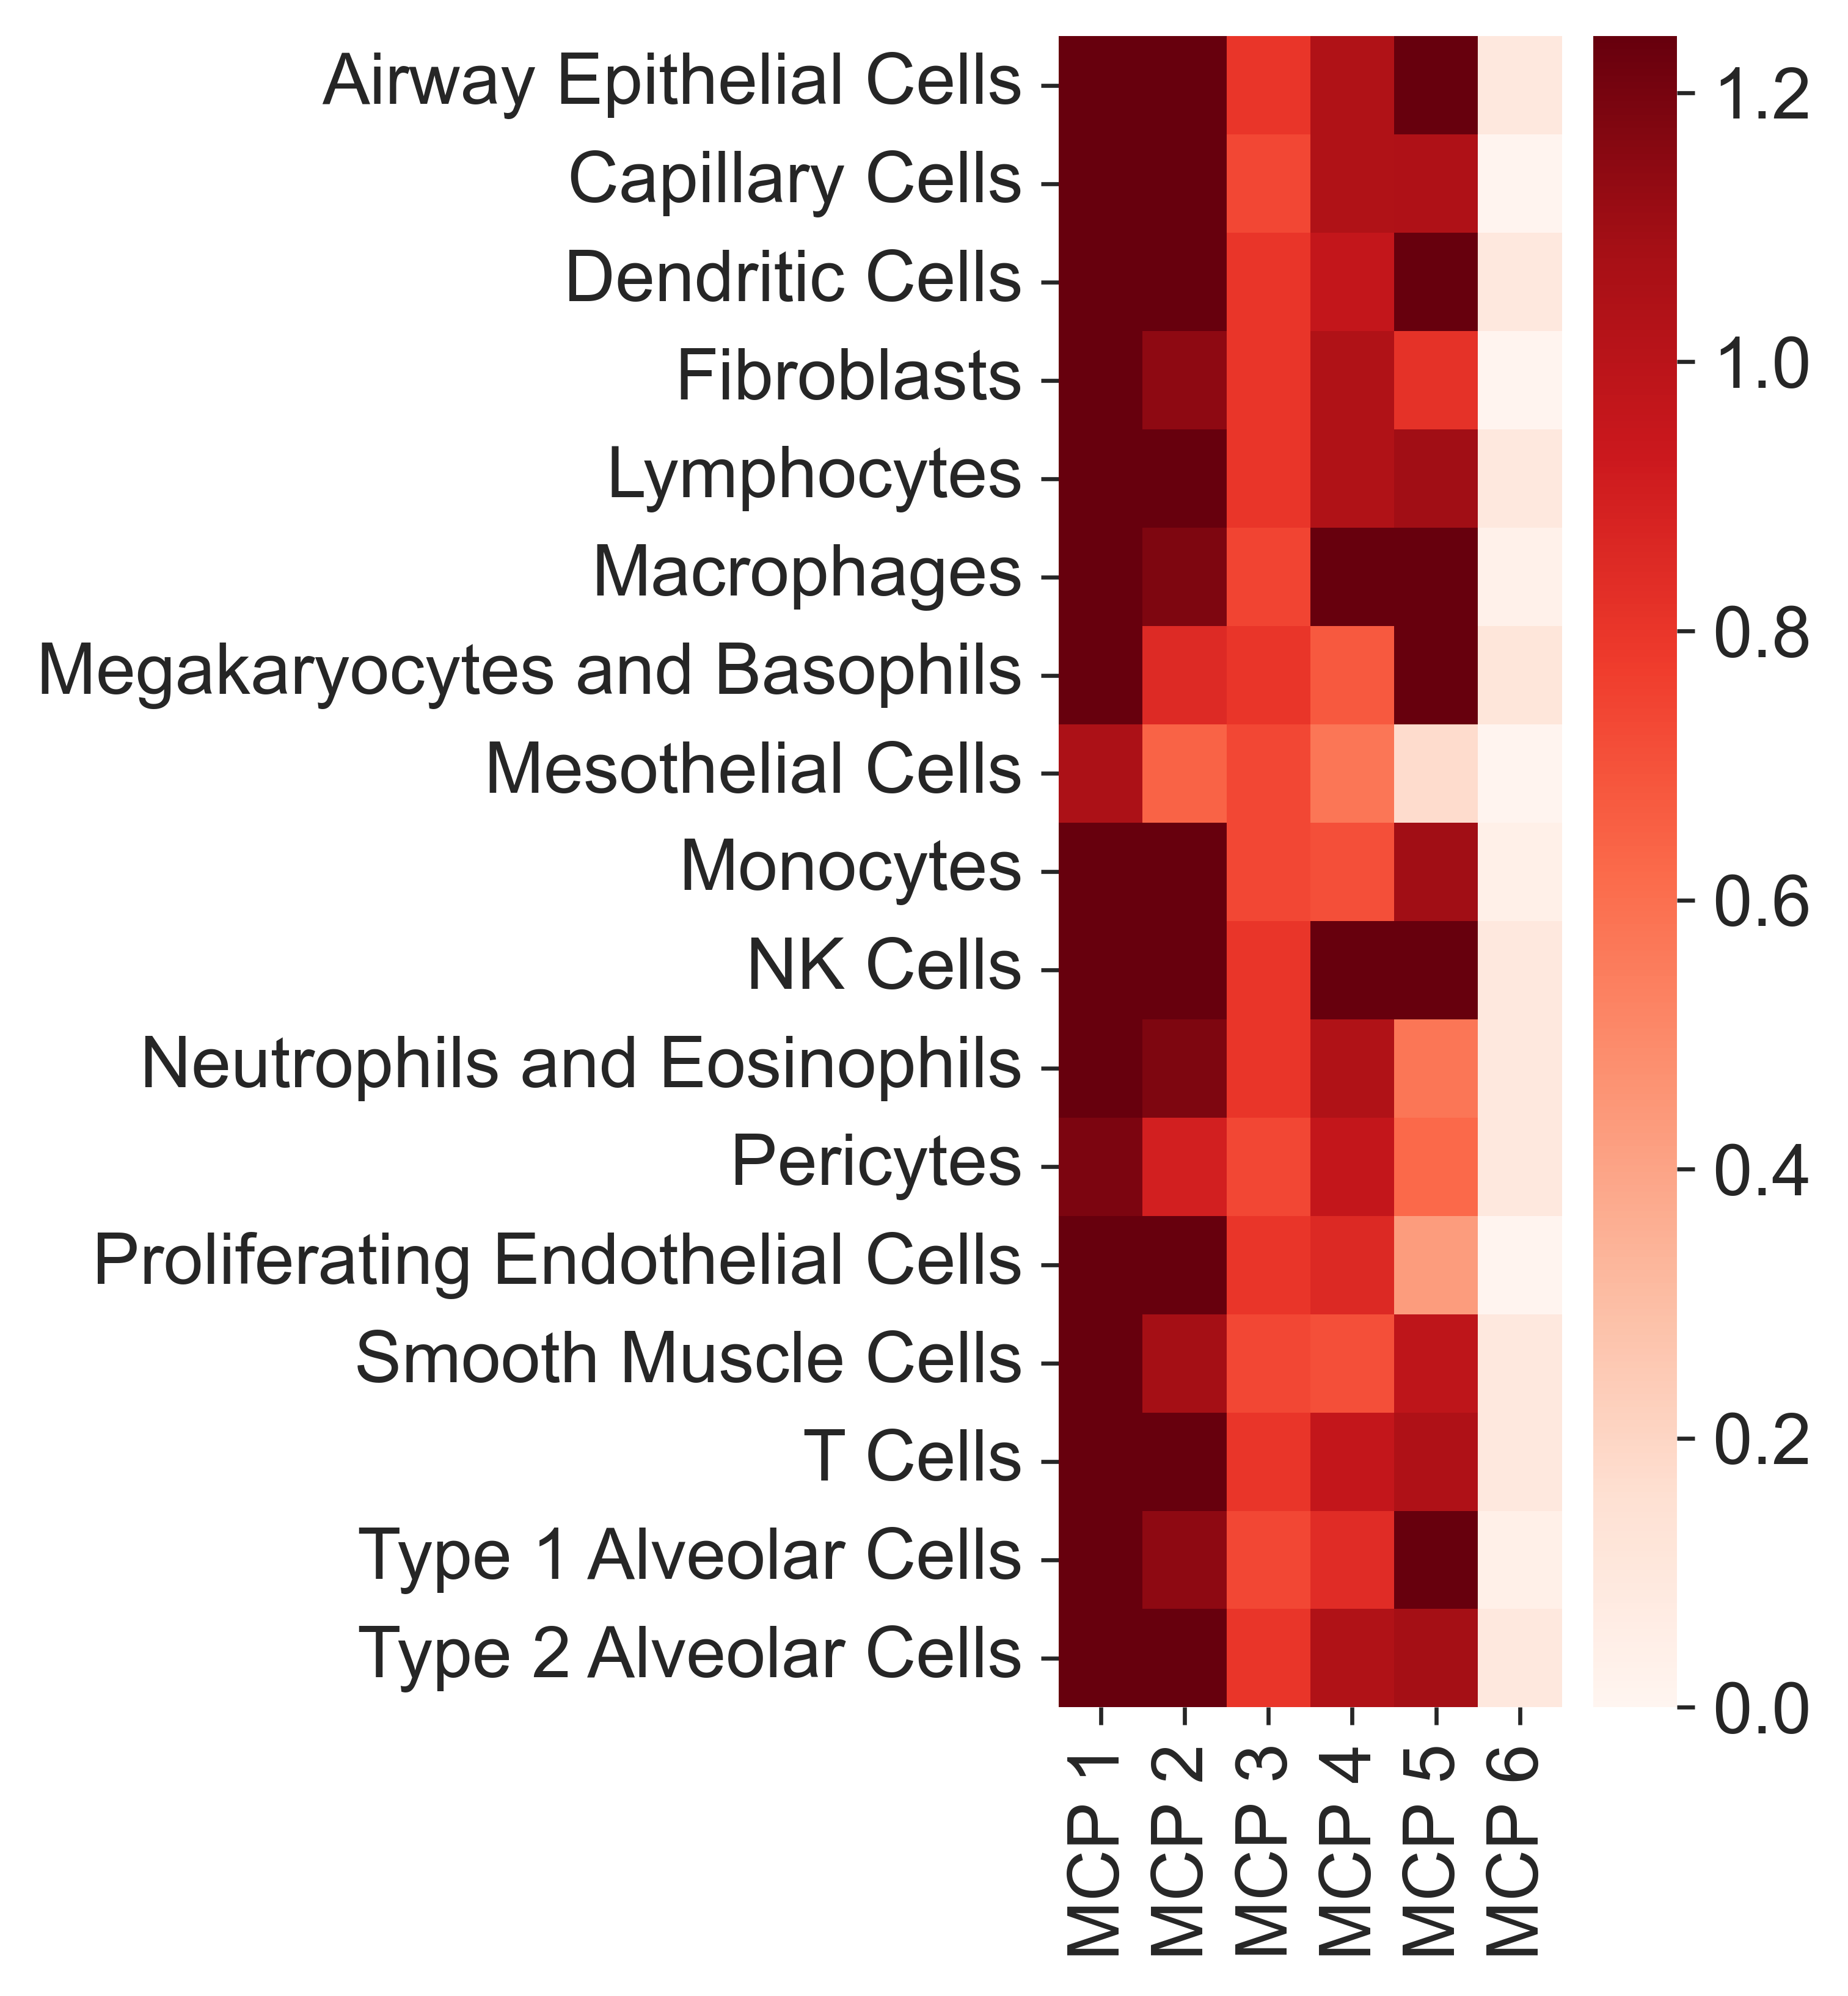

In [81]:
# Save one plot for the colorbar
plot_heatmap(blm_pbs_associations, vmax=global_max, create_fig=True, cbar=True, cmap="Reds")
plt.savefig("figures/heatmap_mcp_associations_colorbar.pdf", bbox_inches="tight")

# Extrema genes: Across all cell types

In [54]:
blm_pbs_extrema_genes = pd.read_pickle("dialogue_output/day 10/blm_pbs_extrema_genes.pickle")
blm_nintedanib_extrema_genes = pd.read_pickle("dialogue_output/day 10/blm_nintedanib_extrema_genes.pickle")
blm_GLPG1690_extrema_genes = pd.read_pickle("dialogue_output/day 10/blm_GLPG1690_extrema_genes.pickle")
blm_GLPG1205_extrema_genes = pd.read_pickle("dialogue_output/day 10/blm_GLPG1205_extrema_genes.pickle")
blm_combo_extrema_genes = pd.read_pickle("dialogue_output/day 10/blm_combo_extrema_genes.pickle")

extrema_genes_dfs = [blm_pbs_extrema_genes, blm_nintedanib_extrema_genes, blm_GLPG1690_extrema_genes, blm_GLPG1205_extrema_genes, blm_combo_extrema_genes]

dict_keys(['Airway Epithelial Cells', 'Capillary Cells', 'Dendritic Cells', 'Fibroblasts', 'Lymphocytes', 'Macrophages', 'Megakaryocytes and Basophils', 'Mesothelial Cells', 'Monocytes', 'NK Cells', 'Neutrophils and Eosinophils', 'Pericytes', 'Proliferating Endothelial Cells', 'Smooth Muscle Cells', 'T Cells', 'Type 1 Alveolar Cells', 'Type 2 Alveolar Cells'])

In [62]:
mcp_genes = {}

for extrema_gene_df, treatment in zip(extrema_genes_dfs, treatments):
    print(treatment)
    mcp_genes[treatment] = {}
    for mcp_nr in range(6):
        mcp_genes[treatment][f"mcp_{mcp_nr}"] = {"names": [], "pvals_adj": []}
        for cell_type in extrema_gene_df[f"mcp_{mcp_nr}"].keys():
            df = extrema_gene_df[f"mcp_{mcp_nr}"][cell_type]
            df = df[df["pvals_adj"] < 0.0001]
            mcp_genes[treatment][f"mcp_{mcp_nr}"]["names"] += df["names"].tolist()
            mcp_genes[treatment][f"mcp_{mcp_nr}"]["pvals_adj"] += df["pvals_adj"].tolist()
            
        mcp_genes[treatment][f"mcp_{mcp_nr}"] = pd.DataFrame(mcp_genes[treatment][f"mcp_{mcp_nr}"])
        print(f"Treatment: {treatment}, MCP: {mcp_nr}, Number of genes: {len(set(mcp_genes[treatment][f'mcp_{mcp_nr}']['names']))}")

BLM+PBS
Treatment: BLM+PBS, MCP: 0, Number of genes: 12586
Treatment: BLM+PBS, MCP: 1, Number of genes: 12971
Treatment: BLM+PBS, MCP: 2, Number of genes: 12836
Treatment: BLM+PBS, MCP: 3, Number of genes: 13124
Treatment: BLM+PBS, MCP: 4, Number of genes: 13229
Treatment: BLM+PBS, MCP: 5, Number of genes: 11259
BLM+Nintedanib
Treatment: BLM+Nintedanib, MCP: 0, Number of genes: 12530
Treatment: BLM+Nintedanib, MCP: 1, Number of genes: 12175
Treatment: BLM+Nintedanib, MCP: 2, Number of genes: 13459
Treatment: BLM+Nintedanib, MCP: 3, Number of genes: 13158
Treatment: BLM+Nintedanib, MCP: 4, Number of genes: 13171
Treatment: BLM+Nintedanib, MCP: 5, Number of genes: 11122
BLM+GLPG1690
Treatment: BLM+GLPG1690, MCP: 0, Number of genes: 12498
Treatment: BLM+GLPG1690, MCP: 1, Number of genes: 13411
Treatment: BLM+GLPG1690, MCP: 2, Number of genes: 12414
Treatment: BLM+GLPG1690, MCP: 3, Number of genes: 13126
Treatment: BLM+GLPG1690, MCP: 4, Number of genes: 13140
Treatment: BLM+GLPG1690, MCP: 

In [60]:
mcp_genes["BLM+Combo"][f"mcp_0"].sort_values(by="pvals_adj")[:100]

,names,pvals_adj
18447,Ly75,0.0
18514,Patj,0.0
18513,Tob1,0.0
18512,C530008M17Rik,0.0
18511,App,0.0
...,...,...
18580,Clec7a,0.0
18579,Fam129a,0.0
18587,Il17ra,0.0
18578,Tor1aip2,0.0


In [63]:
#check how many have p val 0
for treatment in treatments:
    for mcp_nr in range(6):
        print(f"Treatment: {treatment}, MCP: {mcp_nr}, Number of genes with p val 0: {len(mcp_genes[treatment][f'mcp_{mcp_nr}'][mcp_genes[treatment][f'mcp_{mcp_nr}']['pvals_adj'] == 0])}")

Treatment: BLM+PBS, MCP: 0, Number of genes with p val 0: 202
Treatment: BLM+PBS, MCP: 1, Number of genes with p val 0: 300
Treatment: BLM+PBS, MCP: 2, Number of genes with p val 0: 354
Treatment: BLM+PBS, MCP: 3, Number of genes with p val 0: 550
Treatment: BLM+PBS, MCP: 4, Number of genes with p val 0: 448
Treatment: BLM+PBS, MCP: 5, Number of genes with p val 0: 62
Treatment: BLM+Nintedanib, MCP: 0, Number of genes with p val 0: 281
Treatment: BLM+Nintedanib, MCP: 1, Number of genes with p val 0: 158
Treatment: BLM+Nintedanib, MCP: 2, Number of genes with p val 0: 636
Treatment: BLM+Nintedanib, MCP: 3, Number of genes with p val 0: 501
Treatment: BLM+Nintedanib, MCP: 4, Number of genes with p val 0: 579
Treatment: BLM+Nintedanib, MCP: 5, Number of genes with p val 0: 131
Treatment: BLM+GLPG1690, MCP: 0, Number of genes with p val 0: 197
Treatment: BLM+GLPG1690, MCP: 1, Number of genes with p val 0: 559
Treatment: BLM+GLPG1690, MCP: 2, Number of genes with p val 0: 325
Treatment: BLM

In [73]:
gp = GProfiler(return_dataframe=True)

gsea_results = {}
for treatment in treatments:
    print(treatment)
    gsea_results[treatment] = {}
    for mcp_nr in range(6):
        query_genes = mcp_genes[treatment][f"mcp_{mcp_nr}"].sort_values(by="pvals_adj")["names"].drop_duplicates()[:100].tolist()
        results = gp.profile(organism='mmusculus', query=query_genes)
        gsea_results[treatment][f"mcp_{mcp_nr}"] = results

BLM+PBS
BLM+Nintedanib
BLM+GLPG1690
BLM+GLPG1205
BLM+Combo


In [87]:
gsea_results["BLM+Nintedanib"]["mcp_0"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0002376,immune system process,9.597942e-16,True,"""Any process involved in the development or fu...",2819,91,43,26944,0.472527,0.015254,query_1,[GO:0008150]
1,GO:BP,GO:0009605,response to external stimulus,1.682912e-14,True,"""Any process that results in a change in state...",3042,91,43,26944,0.472527,0.014135,query_1,[GO:0050896]
2,GO:BP,GO:0006952,defense response,4.459978e-14,True,"""Reactions, triggered in response to the prese...",1812,91,34,26944,0.373626,0.018764,query_1,[GO:0006950]
3,GO:BP,GO:0048584,positive regulation of response to stimulus,3.512890e-13,True,"""Any process that activates, maintains or incr...",2359,91,37,26944,0.406593,0.015685,query_1,"[GO:0048518, GO:0048583, GO:0050896]"
4,GO:BP,GO:0048518,positive regulation of biological process,6.754113e-13,True,"""Any process that activates or increases the f...",6589,91,59,26944,0.648352,0.008954,query_1,"[GO:0008150, GO:0050789]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,GO:BP,GO:0019216,regulation of lipid metabolic process,4.780987e-02,True,"""Any process that modulates the frequency, rat...",357,91,8,26944,0.087912,0.022409,query_1,"[GO:0006629, GO:0080090]"
346,GO:BP,GO:0071347,cellular response to interleukin-1,4.850085e-02,True,"""Any process that results in a change in state...",105,91,5,26944,0.054945,0.047619,query_1,"[GO:0070555, GO:0071345]"
347,HP,HP:0034601,Decreased circulating C1q concentration,4.906770e-02,True,Concentration or activity of the C1q protein i...,2,34,2,5098,0.058824,1.000000,query_1,[HP:0004431]
348,HP,HP:0002354,Memory impairment,4.984590e-02,True,An impairment of memory as manifested by a red...,149,34,7,5098,0.205882,0.046980,query_1,[HP:0100543]


In [86]:
gsea_results["BLM+Nintedanib"]["mcp_5"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0022626,cytosolic ribosome,8.901678e-56,True,"""A ribosome located in the cytosol."" [GOC:mtg_...",130,94,35,26995,0.372340,0.269231,query_1,"[GO:0005829, GO:0005840]"
1,GO:CC,GO:0044391,ribosomal subunit,2.390758e-54,True,"""Either of the two subunits of a ribosome: the...",202,94,38,26995,0.404255,0.188119,query_1,"[GO:0005840, GO:1990904]"
2,GO:BP,GO:0002181,cytoplasmic translation,8.795862e-52,True,"""The chemical reactions and pathways resulting...",158,93,35,26944,0.376344,0.221519,query_1,[GO:0006412]
3,REAC,REAC:R-MMU-1799339,SRP-dependent cotranslational protein targetin...,6.230173e-48,True,SRP-dependent cotranslational protein targetin...,92,63,33,8405,0.523810,0.358696,query_1,[REAC:R-MMU-72766]
4,REAC,REAC:R-MMU-975956,Nonsense Mediated Decay (NMD) independent of t...,1.477689e-47,True,Nonsense Mediated Decay (NMD) independent of t...,94,63,33,8405,0.523810,0.351064,query_1,[REAC:R-MMU-927802]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,GO:BP,GO:2000404,regulation of T cell migration,4.467549e-02,True,"""Any process that modulates the frequency, rat...",49,93,4,26944,0.043011,0.081633,query_1,"[GO:0072678, GO:2000401]"
273,GO:MF,GO:0016493,C-C chemokine receptor activity,4.534860e-02,True,"""Combining with a C-C chemokine and transmitti...",23,90,3,25063,0.033333,0.130435,query_1,[GO:0004950]
274,HP,HP:0032309,Abnormal granulocyte count,4.954457e-02,True,Any deviation from the normal cell count per v...,257,35,9,5098,0.257143,0.035019,query_1,"[HP:0001911, HP:0011893]"
275,GO:CC,GO:0005587,collagen type IV trimer,4.981020e-02,True,"""A collagen heterotrimer containing type IV al...",6,94,2,26995,0.021277,0.333333,query_1,"[GO:0098642, GO:0098651]"


In [85]:
gsea_results["BLM+Nintedanib"]["mcp_0"][gsea_results["BLM+Nintedanib"]["mcp_0"]["source"] == "KEGG"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
60,KEGG,KEGG:04142,Lysosome,0.000001,True,Lysosome,135,62,10,9330,0.161290,0.074074,query_1,[KEGG:00000]
130,KEGG,KEGG:04612,Antigen processing and presentation,0.000082,True,Antigen processing and presentation,82,62,7,9330,0.112903,0.085366,query_1,[KEGG:00000]
140,KEGG,KEGG:04145,Phagosome,0.000144,True,Phagosome,173,62,9,9330,0.145161,0.052023,query_1,[KEGG:00000]
146,KEGG,KEGG:04210,Apoptosis,0.000227,True,Apoptosis,136,62,8,9330,0.129032,0.058824,query_1,[KEGG:00000]
188,KEGG,KEGG:04650,Natural killer cell mediated cytotoxicity,0.000942,True,Natural killer cell mediated cytotoxicity,118,62,7,9330,0.112903,0.059322,query_1,[KEGG:00000]
269,KEGG,KEGG:05150,Staphylococcus aureus infection,0.011225,True,Staphylococcus aureus infection,121,62,6,9330,0.096774,0.049587,query_1,[KEGG:00000]
272,KEGG,KEGG:05133,Pertussis,0.011833,True,Pertussis,77,62,5,9330,0.080645,0.064935,query_1,[KEGG:00000]
292,KEGG,KEGG:04380,Osteoclast differentiation,0.017337,True,Osteoclast differentiation,131,62,6,9330,0.096774,0.045802,query_1,[KEGG:00000]
300,KEGG,KEGG:05416,Viral myocarditis,0.021034,True,Viral myocarditis,87,62,5,9330,0.080645,0.057471,query_1,[KEGG:00000]
310,KEGG,KEGG:04979,Cholesterol metabolism,0.025464,True,Cholesterol metabolism,50,62,4,9330,0.064516,0.080000,query_1,[KEGG:00000]


In [41]:
gsea_results["mcp_0"][gsea_results["mcp_0"]["source"] == "REAC"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
21,REAC,REAC:R-MMU-5620924,Intraflagellar transport,0.011924,True,Intraflagellar transport,54,12,3,8405,0.25,0.055556,query_1,[REAC:R-MMU-5617833]


In [50]:
gsea_results["mcp_1"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0005929,cilium,1.869519e-09,True,"""A specialized eukaryotic organelle that consi...",775,43,14,26995,0.325581,0.018065,query_1,"[GO:0043227, GO:0120025]"
1,GO:CC,GO:0005930,axoneme,9.721987e-08,True,"""The bundle of microtubules and associated pro...",182,43,8,26995,0.186047,0.043956,query_1,"[GO:0005856, GO:0097014, GO:0110165]"
2,GO:CC,GO:0097014,ciliary plasm,1.015466e-07,True,"""All of the contents of a cilium, excluding th...",183,43,8,26995,0.186047,0.043716,query_1,"[GO:0005929, GO:0032838]"
3,GO:CC,GO:0005879,axonemal microtubule,1.874931e-06,True,"""A microtubule in the axoneme of a eukaryotic ...",44,43,5,26995,0.116279,0.113636,query_1,"[GO:0005881, GO:0005930]"
4,GO:CC,GO:0032838,plasma membrane bounded cell projection cytoplasm,3.582258e-06,True,"""All of the contents of a plasma membrane boun...",288,43,8,26995,0.186047,0.027778,query_1,"[GO:0099568, GO:0120025]"
5,GO:CC,GO:0099568,cytoplasmic region,9.345885e-06,True,"""Any (proper) part of the cytoplasm of a singl...",326,43,8,26995,0.186047,0.024540,query_1,[GO:0005737]
6,GO:BP,GO:0044782,cilium organization,2.406353e-05,True,"""A process that is carried out at the cellular...",416,42,9,26944,0.214286,0.021635,query_1,"[GO:0006996, GO:0120036]"
7,GO:CC,GO:0015630,microtubule cytoskeleton,2.996418e-05,True,"""The part of the cytoskeleton (the internal fr...",1380,43,13,26995,0.302326,0.009420,query_1,[GO:0005856]
8,HP,HP:0009799,Supernumerary spleens,6.116302e-05,True,The presence of two or more accessory spleens.,101,7,5,5098,0.714286,0.049505,query_1,[HP:0025408]
9,GO:CC,GO:0036064,ciliary basal body,8.714329e-05,True,"""A membrane-tethered, short cylindrical array ...",179,43,6,26995,0.139535,0.033520,query_1,"[GO:0005815, GO:0005929]"


In [ ]:
cell_circuit = ["Aberrant Basaloid", "SPP1+ Macrophages", "Myofibroblasts", "Pericytes"]
#TODO: Where VWA1/PLVAP cells???

In [82]:
blm_pbs_extrema_genes[f"mcp_0"].keys()

dict_keys(['Airway Epithelial Cells', 'Capillary Cells', 'Dendritic Cells', 'Fibroblasts', 'Lymphocytes', 'Macrophages', 'Megakaryocytes and Basophils', 'Mesothelial Cells', 'Monocytes', 'NK Cells', 'Neutrophils and Eosinophils', 'Pericytes', 'Proliferating Endothelial Cells', 'Smooth Muscle Cells', 'T Cells', 'Type 1 Alveolar Cells', 'Type 2 Alveolar Cells'])

# Extrema genes: Per cell type

In [ ]:
gp = GProfiler(return_dataframe=True)

gsea_results = {}

for extrema_gene_df, treatment in zip(extrema_genes_dfs, treatments):
    print(treatment)
    gsea_results[treatment] = {}
    
    for mcp_nr in tqdm(range(6)):
        gsea_results[treatment][f"mcp_{mcp_nr}"] = {}
        
        for cell_type in extrema_gene_df[f"mcp_{mcp_nr}"].keys():
            df = extrema_gene_df[f"mcp_{mcp_nr}"][cell_type]
            
            query_genes = df.sort_values(by="pvals_adj")["names"].drop_duplicates()[:100].tolist()
            results = gp.profile(organism='mmusculus', query=query_genes)
            gsea_results[treatment][f"mcp_{mcp_nr}"][cell_type] = results